In [31]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import LeaveOneOut
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
import matplotlib.pyplot as plt
import plotly.express as px
import os


#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
schaefer_labels = load_parcellation('schaefer', scale=1000, join=True)

In [3]:
dep_path = 'clean_data/dep/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

# Log Model on Gradients

## Get train & test data

In [49]:
dep_subjects = np.loadtxt('preprocessing/Bezmaternykh_dep_subjects.txt', dtype = str)
control_subjects = np.loadtxt('preprocessing/Bezmaternykh_controls_subjects.txt', dtype = str)
subjects = np.concatenate((dep_subjects, control_subjects))

In [5]:
len(dep_subjects)

51

In [6]:
len(control_subjects)

21

In [7]:
# train sample

dep_subjects_train = dep_subjects[:30]
control_subjects_train = control_subjects[:15]
subjects_train = np.concatenate((control_subjects_train, dep_subjects_train))

group_train = np.zeros(len(dep_subjects_train) + len(control_subjects_train))
group_train[:len(dep_subjects_train)] = 1
group_train = group_train.astype(bool)
data_train = np.stack((subjects_train, group_train))

In [8]:
data_train.shape

(2, 45)

In [9]:
# test sample 

dep_subjects_test = dep_subjects[30:]
control_subjects_test = control_subjects[15:]
subjects_test = np.concatenate((dep_subjects_test, control_subjects_test))

group_test = np.zeros(len(dep_subjects_test) + len(control_subjects_test))
group_test[:len(dep_subjects_test)] = 1
group_test = group_test.astype(bool)
data_test = np.stack((subjects_test, group_test))

In [10]:
data_test.shape

(2, 27)

In [11]:
subject_df_train = pd.DataFrame(data_train.T, columns = ['Subject', 'Group'])
subject_df_test = pd.DataFrame(data_test.T, columns = ['Subject', 'Group'])

In [12]:
# train grads
dep_grads_train = []
for subject in dep_subjects_train:
    grads = np.load(f'{dep_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    dep_grads_train.append(grads)
dep_grads_train = np.stack(dep_grads_train)

control_grads_train = []
for subject in control_subjects_train:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads_train.append(grads)
control_grads_train = np.stack(control_grads_train)


In [13]:
# test grads
dep_grads_test = []
for subject in dep_subjects_test:
    grads = np.load(f'{dep_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    dep_grads_test.append(grads)
dep_grads_test = np.stack(dep_grads_test)

control_grads_test = []
for subject in control_subjects_test:
    grads = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')
    control_grads_test.append(grads)
control_grads_test = np.stack(control_grads_test)

In [62]:
# for the LOO CV version
X_grads = np.row_stack([dep_grads_train, dep_grads_test, control_grads_train, control_grads_test])
y_grads = np.concatenate([np.ones(dep_grads_train.shape[0] + dep_grads_test.shape[0]), np.zeros(control_grads_train.shape[0] + control_grads_test.shape[0])]).astype(int)
y_grads


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [14]:
train_grads = np.row_stack((dep_grads_train, control_grads_train))
test_grads = np.row_stack((dep_grads_test, control_grads_test))

In [15]:
train_grads.shape


(45, 1000, 10)

In [16]:
test_grads.shape

(27, 1000, 10)

## Prepare Input

In [78]:
X_train_grads = train_grads[:, :, :6].reshape(train_grads.shape[0], -1)
y_train = subject_df_train['Group'].values

X_test_grads = test_grads[:, :, :6].reshape(test_grads.shape[0], -1)
y_test = subject_df_test['Group'].values


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)


In [18]:
X_train_grads = train_grads[:, :, :5]
X_train_grads.shape

(45, 1000, 5)

In [19]:
X_train_grads[8]

array([[ 1.19147473, -0.20011131,  1.17300385,  0.4386363 , -0.14005696],
       [-0.7001474 ,  0.42906215,  2.83704736, -1.48595724,  0.49208714],
       [-1.06607048,  0.83620527,  1.77166522,  0.05389165,  0.32473328],
       ...,
       [ 5.45713499,  0.65073931, -1.69672385,  0.59014435, -0.1469945 ],
       [ 0.10279296, -0.82214421,  0.94126227,  1.18538157,  0.91726404],
       [ 5.36562318,  0.02705404, -0.3861956 ,  0.10849027, -1.31796984]])

## Train & Test Model on Gradients

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

perf_df_grads = pd.DataFrame(columns = ['N_grads', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])

acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

for n_grads in range(1, 11):
    X_grads = train_grads[:, :, :n_grads].reshape(train_grads.shape[0], -1)
    X_test_grads = test_grads[:, :, :n_grads].reshape(test_grads.shape[0], -1)

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_grads, y_train)

    y_prob = clf.predict_proba(X_test_grads)
    y_pred = clf.predict(X_test_grads)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df_grads['N_grads'] = np.arange(1, 11)
perf_df_grads['Accuracy'] = acc_list
perf_df_grads['Precision'] = prec_list
perf_df_grads['Recall'] = rec_list
perf_df_grads['F1'] = f1_list
perf_df_grads['ROC_AUC'] = roc_auc_list
perf_df_grads['Deviance'] = deviance_list



# OPENNEURO: Depression

In [21]:
perf_df_grads

,N_grads,Accuracy,Precision,Recall,F1,ROC_AUC,Deviance
0,1,0.666667,0.750000,0.857143,0.800000,0.579365,16.109818
1,2,0.703704,0.760000,0.904762,0.826087,0.460317,14.046470
2,3,0.777778,0.777778,1.000000,0.875000,0.460317,14.121332
3,4,0.777778,0.777778,1.000000,0.875000,0.460317,11.887174
4,5,0.777778,0.777778,1.000000,0.875000,0.500000,10.511655
5,6,0.777778,0.777778,1.000000,0.875000,0.547619,7.749010
6,7,0.777778,0.777778,1.000000,0.875000,0.500000,9.738346
7,8,0.777778,0.777778,1.000000,0.875000,0.515873,8.965885
8,9,0.777778,0.777778,1.000000,0.875000,0.539683,8.945083
9,10,0.777778,0.777778,1.000000,0.875000,0.523810,10.185570


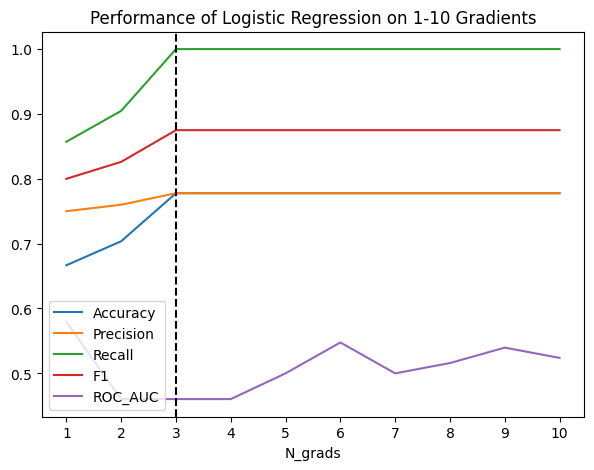

In [22]:
perf_df_grads.plot(x = 'N_grads', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (7, 5), title = 'Performance of Logistic Regression on 1-10 Gradients')
plt.xticks(perf_df_grads['N_grads'])
plt.axvline(perf_df_grads['N_grads'][(perf_df_grads['Accuracy'].idxmax() & perf_df_grads['Precision'].idxmax())], color = 'k', linestyle = '--')

## Train & Test Model on Gradients + LOO CV

In [66]:
# fit model with LOO CV

perf_df_disp = pd.DataFrame(columns = ['N_grads', 'Accuracy', 'Precision', 'Recall', 'F1', 'Deviance'])
dfs = []

loo = LeaveOneOut()

for n_grads in range(1, 11):
    acc_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    roc_auc_list = []
    deviance_list = []

    X_grad_sample = X_grads[:, :, :n_grads].reshape(X_grads.shape[0], -1)
    clf = LogisticRegression(max_iter=10000)

    for train_index, test_index in loo.split(X_grad_sample):
        X_train_disp, X_test_disp = X_grad_sample[train_index], X_grad_sample[test_index]
        y_train, y_test = y_grads[train_index], y_grads[test_index]

        clf.fit(X_train_disp, y_train)

        y_prob = clf.predict_proba(X_test_disp)
        y_pred = clf.predict(X_test_disp)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label=1)
        rec = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        #roc_auc = roc_auc_score(y_test, y_prob[:, 1])

        log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
        log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
        deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        #roc_auc_list.append(roc_auc)
        deviance_list.append(deviance)

    perf_df_grads_temp = pd.DataFrame({
        'N_grads': [n_grads] * len(y_grads),
        'Accuracy': acc_list,
        'Precision': prec_list,
        'Recall': rec_list,
        'F1': f1_list,
        #'ROC_AUC': roc_auc_list,
        'Deviance': deviance_list
    })

    dfs.append(perf_df_grads_temp)

perf_df_grads = pd.concat(dfs, ignore_index=True)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/718294276.py:34: RuntimeWarning: divide by zero encountered in log
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/718294276.py:34: RuntimeWarning: invalid value encountered in multiply
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/718294276.py:34: RuntimeWarning: divide by zero encountered in log
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/718294276.py:34: RuntimeWarning: invalid value encountered in multiply
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var/fol

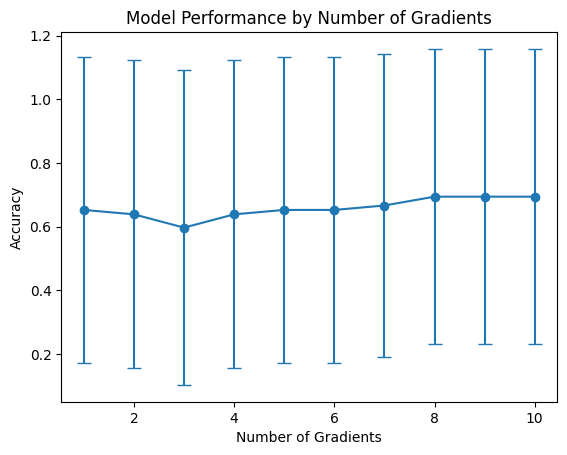

In [67]:
# group performance data by number of neighbors and calculate mean accuracy and standard deviation
grouped_data = perf_df_grads.groupby(['N_grads']).agg({'Accuracy': ['mean', 'std']}).reset_index()
grouped_data.columns = ['N_grads', 'Mean Accuracy', 'Standard Deviation']

# plot mean accuracy with error bars representing one standard deviation
plt.errorbar(grouped_data['N_grads'], grouped_data['Mean Accuracy'], yerr=grouped_data['Standard Deviation'], fmt='o-', capsize=5)

# add axis labels and title
plt.xlabel('Number of Gradients')
plt.ylabel('Accuracy')
plt.title('Model Performance by Number of Gradients')

plt.show()

# Log Model on Dispersion

In [23]:
n_neighbours_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]


In [68]:
n_grads = 6

In [71]:
# Compute dispersion

for n_neighbours in n_neighbours_list:
    for subject in dep_subjects:
        gradients = np.load(f'{dep_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
        hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
        distances, indices = hcp_ngbrs.kneighbors(gradients)
        subj_disp = distances.mean(axis = 1)
        np.save(f'{dep_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

    for subject in control_subjects:
        gradients = np.load(f'{controls_path}/sub-{subject}/func/aligned_10grads_{subject}_schaefer1000.npy')[:, :n_grads]
        hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
        distances, indices = hcp_ngbrs.kneighbors(gradients)
        subj_disp = distances.mean(axis = 1)
        np.save(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy', subj_disp)

In [99]:
dep_subjects_test.shape

(21,)

## Prepare Disp Input

In [72]:
# load train & test dispersion in dicts

disp_dict_train = {}
disp_dict_test = {}

for n_neighbours in n_neighbours_list:
    disp_train = []
    for subject in dep_subjects_train:
        disp = np.load(f'{dep_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_train.append(disp)
    for subject in control_subjects_train:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_train.append(disp)

    disp_train = np.stack(disp_train)
    disp_dict_train[n_neighbours] = disp_train

    disp_test = []
    for subject in dep_subjects_test:
        disp = np.load(f'{dep_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_test.append(disp)
    for subject in control_subjects_test:
        disp = np.load(f'{controls_path}/sub-{subject}/func/disp_{n_grads}_{n_neighbours}n_{subject}_schaefer1000.npy')
        disp_test.append(disp)

    disp_test = np.stack(disp_test)
    disp_dict_test[n_neighbours] = disp_test
    


## Train & Test Model on Dispersion

In [75]:
X_train_disp.shape

(45, 1000)

In [76]:
y_train.shape

(71,)

In [74]:
perf_df_disp = pd.DataFrame(columns = ['N_neighbours', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'Deviance'])

acc_list = []
prec_list = []
rec_list = []
f1_list = []
roc_auc_list = []
deviance_list = []

np.random.seed(0)

for n_neighbours in n_neighbours_list:
    X_train_disp = disp_dict_train[n_neighbours]
    X_test_disp = disp_dict_test[n_neighbours]

    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_disp, y_train)

    y_prob = clf.predict_proba(X_test_disp)
    y_pred = clf.predict(X_test_disp)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
    log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
    deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    deviance_list.append(deviance)

perf_df_disp['N_neighbours'] = n_neighbours_list
perf_df_disp['Accuracy'] = acc_list
perf_df_disp['Precision'] = prec_list
perf_df_disp['Recall'] = rec_list
perf_df_disp['F1'] = f1_list
perf_df_disp['ROC_AUC'] = roc_auc_list
perf_df_disp['Deviance'] = deviance_list



ValueError: Found input variables with inconsistent numbers of samples: [45, 71]

In [29]:
perf_df_disp

,N_neighbours,Accuracy,Precision,Recall,F1,ROC_AUC,Deviance
0,5,0.777778,0.777778,1.000000,0.875000,0.460317,2.668084
1,10,0.703704,0.760000,0.904762,0.826087,0.468254,3.444276
2,15,0.666667,0.750000,0.857143,0.800000,0.484127,3.753332
3,20,0.666667,0.750000,0.857143,0.800000,0.460317,4.040709
4,25,0.666667,0.750000,0.857143,0.800000,0.468254,4.407480
5,30,0.666667,0.750000,0.857143,0.800000,0.468254,4.608435
6,35,0.703704,0.760000,0.904762,0.826087,0.444444,4.834099
7,40,0.703704,0.760000,0.904762,0.826087,0.452381,5.077441
8,45,0.703704,0.760000,0.904762,0.826087,0.452381,5.274631
9,50,0.703704,0.760000,0.904762,0.826087,0.452381,5.481296


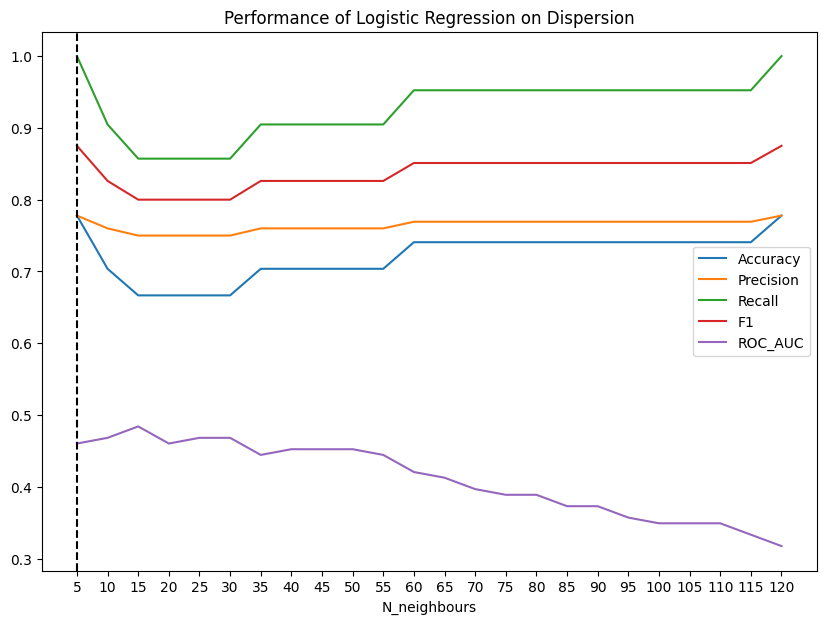

In [30]:
from matplotlib import pyplot as plt

perf_df_disp.plot(x = 'N_neighbours', y = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], figsize = (10, 7), title = 'Performance of Logistic Regression on Dispersion')
# draw a vertical line where accuracy is maximum
#disply every level of n_neighbours on the x-axis
plt.xticks(perf_df_disp['N_neighbours'])
plt.axvline(perf_df_disp['N_neighbours'][perf_df_disp['Accuracy'].idxmax()], color = 'k', linestyle = '--')


## Train & Test Model on Dispersion + LOO CV

In [38]:
n_neighbours = 5
X_disp = np.row_stack((disp_dict_train[n_neighbours], disp_dict_test[n_neighbours]))
y_disp = np.concatenate((y_train, y_test))


(72,)

In [40]:
y_disp

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0])

In [42]:
y_test
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0])

In [46]:
# fit model with LOO CV

perf_df_disp = pd.DataFrame(columns = ['N_neighbours', 'Accuracy', 'Precision', 'Recall', 'F1', 'Deviance'])
dfs = []

loo = LeaveOneOut()

for n_neighbours in n_neighbours_list:
    acc_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    roc_auc_list = []
    deviance_list = []
    X_disp = np.row_stack((disp_dict_train[n_neighbours], disp_dict_test[n_neighbours]))
    clf = LogisticRegression(max_iter=10000)

    for train_index, test_index in loo.split(X_disp):
        X_train_disp, X_test_disp = X_disp[train_index], X_disp[test_index]
        y_train, y_test = y_disp[train_index], y_disp[test_index]

        clf.fit(X_train_disp, y_train)

        y_prob = clf.predict_proba(X_test_disp)
        y_pred = clf.predict(X_test_disp)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label=1)
        rec = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        #roc_auc = roc_auc_score(y_test, y_prob[:, 1])

        log_likelihood_model = np.sum(y_test * np.log(y_prob[:, 1]) + (1 - y_test) * np.log(1 - y_prob[:, 1]))
        log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
        deviance = -2 * (log_likelihood_model - log_likelihood_saturated)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        #roc_auc_list.append(roc_auc)
        deviance_list.append(deviance)

    perf_df_disp_temp = pd.DataFrame({
        'N_neighbours': [n_neighbours] * len(y_disp),
        'Accuracy': acc_list,
        'Precision': prec_list,
        'Recall': rec_list,
        'F1': f1_list,
        #'ROC_AUC': roc_auc_list,
        'Deviance': deviance_list
    })

    dfs.append(perf_df_disp_temp)

perf_df_disp = pd.concat(dfs, ignore_index=True)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/2535376236.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/2535376236.py:33: RuntimeWarning: invalid value encountered in multiply
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/2535376236.py:33: RuntimeWarning: divide by zero encountered in log
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_6494/2535376236.py:33: RuntimeWarning: invalid value encountered in multiply
  log_likelihood_saturated = np.sum(y_test * np.log(np.mean(y_test)) + (1 - y_test) * np.log(1 - np.mean(y_test)))
/var

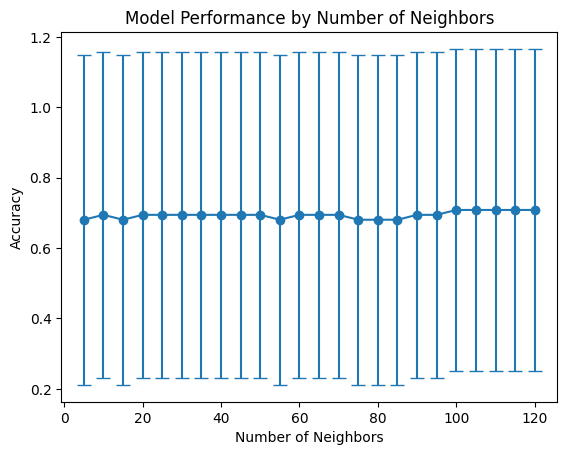

In [48]:
grouped_data = perf_df_disp.groupby(['N_neighbours']).agg({'Accuracy': ['mean', 'std']}).reset_index()
grouped_data.columns = ['N_neighbours', 'Mean Accuracy', 'Standard Deviation']

# plot mean accuracy with error bars representing one standard deviation
plt.errorbar(grouped_data['N_neighbours'], grouped_data['Mean Accuracy'], yerr=grouped_data['Standard Deviation'], fmt='o-', capsize=5)

# add axis labels and title
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Model Performance by Number of Neighbors')

plt.show()

## Permutation test to identify sig. regions

In [23]:
X_train_disp[:, 1].shape

(120,)

In [24]:
X_train_disp = disp_dict_train[80]
X_test_disp = disp_dict_test[80]

In [25]:
regions = np.arange(1, 1001)
np.savetxt("schaefer1000_regions.txt", regions, fmt = '%.0f')

In [26]:
import csv
region = 999

def perm_test_logreg(X_train, y_train, n_permutations=1000, region = region):
    # Initialize empty arrays to store beta coefficients and p-values for each region
    beta_coefficients = np.zeros(X_train.shape[1])
    
    # Fit a logistic regression model to the training data
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train, y_train)

    # Compute the beta coefficients for the logistic regression model
    beta_coefficients = clf.coef_[0]

    # Compute the p-values for the beta coefficients using a permutation test
    np.random.seed(0)

    permuted_feature = np.random.permutation(X_train[:, region])
    permuted_X_train = np.copy(X_train)
    permuted_X_train[:, region] = permuted_feature

    clf_permuted = LogisticRegression(max_iter=10000)
    clf_permuted.fit(permuted_X_train, y_train)

    beta_coefficients_permuted = clf_permuted.coef_[0][region]
    beta_diff = beta_coefficients_permuted - beta_coefficients[region]
    
    permuted_beta_diffs = np.zeros(n_permutations)
    for j in range(n_permutations):
        permuted_y_train = np.random.permutation(y_train)
        clf_permuted_y = LogisticRegression(max_iter=10000)
        clf_permuted_y.fit(permuted_X_train, permuted_y_train)
        permuted_beta_coefficients = clf_permuted_y.coef_[0][region]
        permuted_beta_diffs[j] = permuted_beta_coefficients - beta_coefficients[region]
    
    p_value = np.sum(np.abs(permuted_beta_diffs) >= np.abs(beta_diff)) / n_permutations
    with open('results/logreg_perm_test_res.csv', mode='a', newline='') as csv_file:
        fieldnames = ['p_value', "beta", 'region']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        if csv_file.tell() == 0:  # check if file is empty
            writer.writerow({'p_value': "p_value", "beta": "beta", 'region': "region"})
        writer.writerow({'p_value': p_value, 'beta': beta_coefficients[region], 'region': region + 1})

In [28]:
dep_group_grads = np.load(f'{dep_path}/aligned_schz_group_10grads_schaefer1000.npy')
control_group_grads = np.load(f'{controls_path}/aligned_control_group_10grads_schaefer1000.npy')

In [29]:
X_train_disp.shape
y_train.shape

(120,)

In [30]:
results = pd.read_csv('logreg_perm_test_res.csv')
results["Sig"] = False
results.loc[results["p_value"] <= 0.05, ["Sig"]]= True
results["Grad1_dep"] = dep_group_grads[:, 0]
results["Grad1_Control"] = control_group_grads[:, 0]
results["Grad2_dep"] = dep_group_grads[:, 1]
results["Grad2_Control"] = control_group_grads[:, 1]
results["Grad3_dep"] = dep_group_grads[:, 2]
results["Grad3_Control"] = control_group_grads[:, 2]


In [31]:
sig_df = results[results['Sig']].reset_index()

In [32]:
fig1 = px.scatter(results, x="Grad2_dep", y="Grad1_dep",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=0.08)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         showbackground=True,
                         backgroundcolor='white',
                         gridcolor="rgb(220, 220, 220)",
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False),
                    yaxis=dict(
                        showbackground=True,
                        backgroundcolor='white',
                        gridcolor="rgb(220, 220, 220)",
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False)),
                    width=700,
                    height=500,
                    margin=dict(r=10, l=10, b=10, t=10))

fig2 = px.scatter(sig_df, x="Grad2_dep", y="Grad1_dep",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=1.0)
fig1.add_trace(fig2.data[0])
fig1.show()


In [33]:
fig1 = px.scatter(results, x="Grad2_Control", y="Grad1_Control",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=0.08)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         showbackground=True,
                         backgroundcolor='white',
                         gridcolor="rgb(220, 220, 220)",
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False),
                    yaxis=dict(
                        showbackground=True,
                        backgroundcolor='white',
                        gridcolor="rgb(220, 220, 220)",
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False)),
                    width=700,
                    height=500,
                    margin=dict(r=10, l=10, b=10, t=10))

fig2 = px.scatter(sig_df, x="Grad2_Control", y="Grad1_Control",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=1.0)
fig1.add_trace(fig2.data[0])
fig1.show()

In [34]:
import plotly.express as px

fig1 = px.scatter_3d(results, x="Grad2_dep", y="Grad1_dep", z="Grad3_dep",
              color_continuous_scale='Bluered', color='beta', opacity=0.3)
# Create a copy of the initial scatter plot and modify it to only show significant dots with a different color

fig1.update_traces(marker_size=5)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         backgroundcolor="white",
                         gridcolor="rgb(220, 220, 220)",
                         showbackground=True,
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False),
                    yaxis=dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False),
                    zaxis=dict(
                        backgroundcolor="white",
                        gridcolor="rgb(220, 220, 220)",
                        showbackground=True,
                        zerolinecolor="white",
                        title="Gradient 3",
                        showticklabels=False)),
                    width=700,
                    height=500,
                    margin=dict(r=10, l=10, b=10, t=10))
fig2 = px.scatter_3d(sig_df, x="Grad2_dep", y="Grad1_dep", z="Grad3_dep",
              color='beta', color_continuous_scale='Bluered', opacity=1.0)
fig1.add_trace(fig2.data[0])
fig1.show()

## Plot results on control 1st grad

In [48]:
sig_regions = results["Sig"].values

In [49]:
sig_region_effect = np.zeros((1000))
sig_region_effect[:] = np.nan
sig_region_effect[sig_regions == True]  = results["beta"].values[sig_regions == True]

In [50]:
results["beta"].values[sig_regions == True]

array([ 0.0383942 ,  0.00340695,  0.06374755, -0.04501805, -0.13135384,
       -0.03777134,  0.10963997, -0.14771635, -0.00614462, -0.38193085,
        0.09344675,  0.05582711, -0.04847695, -0.0895011 ,  0.14369879,
       -0.16801373, -0.19851753, -0.03097096, -0.01401264,  0.07944625,
       -0.13681568, -0.08712567, -0.15246304,  0.05453908, -0.07302381,
       -0.03585372,  0.03584319, -0.15945309, -0.28523935, -0.13340846,
        0.0075728 ,  0.2756622 , -0.21012307, -0.03597933])

In [51]:
sig_regions_vis = map_to_labels(sig_regions, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)
sig_region_effect_vis = map_to_labels(sig_region_effect, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

In [52]:
control_1grad_aligned_vis = map_to_labels(control_group_grads[:, 0], schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

In [53]:
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
lh_parc, rh_parc = load_parcellation('schaefer')

In [56]:
np.unique(sig_region_effect_vis*100)

array([-38.193085  , -28.52393538, -21.01230676, -19.85175308,
       -16.80137278, -15.94530933, -15.24630354, -14.77163457,
       -13.68156835, -13.34084619, -13.13538436,  -8.95010986,
        -8.71256666,  -7.30238121,  -4.84769514,  -4.50180474,
        -3.77713414,  -3.58537202,  -3.09709559,  -1.40126432,
        -0.61446245,   0.34069504,   0.75728011,   3.5843185 ,
         3.83942023,   5.45390771,   5.58271103,   6.37475461,
         7.94462463,   9.34467495,  10.96399736,  14.36987874,
        27.56622007,          nan])

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_7173/3150529044.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



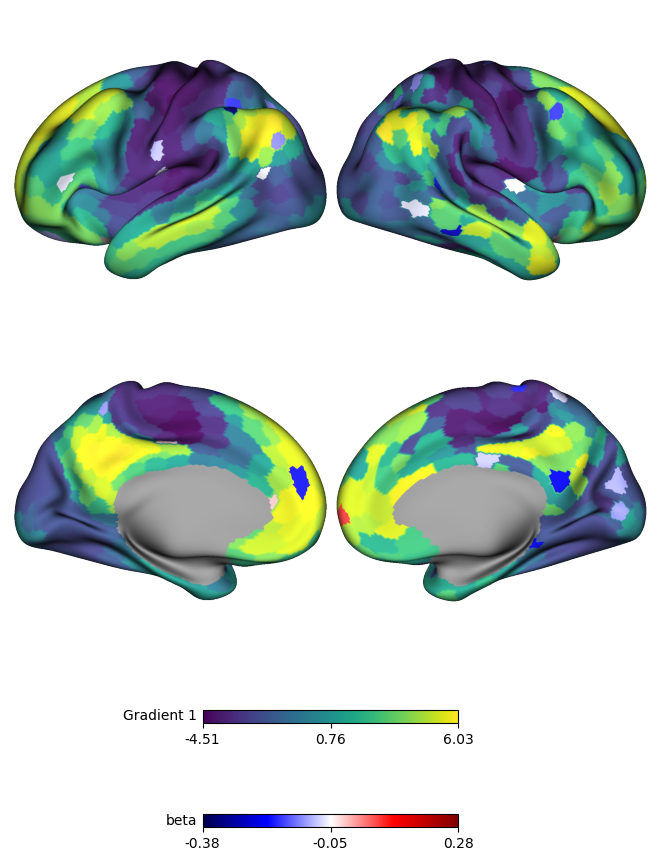

In [64]:
result_coefs = Plot(lh, rh,  size=(1000, 1000), zoom = 1.25)

result_coefs.add_layer({'left': control_1grad_aligned_vis[:32492], 'right': control_1grad_aligned_vis[32492:]}, cbar=True, cmap = "viridis", cbar_label= "Gradient 1")
result_coefs.add_layer({'left': sig_region_effect_vis[:32492]*10, 'right': sig_region_effect_vis[32492:]*10}, as_outline= False, cmap='seismic', cbar=True, cbar_label="beta", color_range = (np.nanmin(sig_region_effect_vis), np.nanmax(sig_region_effect_vis)))

fig = result_coefs.build(scale = (2, 2))
fig.show()
#result_t.show(embed_nb = True, scale=(10, 10))